In [1]:
from pandas_datareader.data import DataReader
import requests_cache
import pandas as pd
import numpy as np
from matplotlib import pyplot
import pandas_ta as pta

### Scrapping & Preparing Data from Web

In [2]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_adj_close(tickers, start_date, end_date):
    returns_df = pd.DataFrame()
    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        try:
          s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
          returns_df[ticker] = s['Adj Close']
        except:
          print(ticker)
    return returns_df

In [3]:
data = pd.read_csv('C:\\Users\\Guo Xiong\\Documents\\Y3S1\\BT4222\\Project\\Facebook Final.csv')
data = data.sort_values(by = 'Date')
data['Sentiment'] = data.apply(lambda x:x['probability'] if x['sentiment'] =='POSITIVE' else -x['probability'],axis=1)
data = data.drop(['probability', 'sentiment'], axis=1)
data.head(2).append(data.tail(2))

,Date,Text,neg,neu,pos,compound,0,1,2,3,4,5,6,7,8,9,Sentiment
18580,2007-03-06,I had the unusual opportunity to emcee Silicon...,0.000,0.748,0.252,0.9347,0.166313,0.088513,0.348379,0.252587,0.000000,0.140391,0.000000,0.000000,0.000000,0.0,0.998591
18579,2007-04-20,Virginia Tech Media FrenzyThis week the media ...,0.171,0.782,0.048,-0.7845,0.268237,0.000000,0.168654,0.403765,0.000000,0.000000,0.000000,0.000000,0.156501,0.0,0.719703
6823,2021-11-12,"Veru: ""I think that the prostate cancer drug i...",0.073,0.778,0.149,0.5574,0.000000,0.000000,0.000000,0.000000,0.133768,0.000000,0.000000,0.080252,0.780636,0.0,0.754224
6821,2021-11-12,Mastercard CEO Michael Miebach on Wednesday ex...,0.063,0.868,0.069,0.0772,0.162667,0.000000,0.141604,0.000000,0.192318,0.000000,0.067744,0.000000,0.432743,0.0,-0.983788


In [4]:
FB_start_date = '2016-01-01'  # Using earlier dates for calculation of SMA later
FB_end_date = '2020-01-28'

In [5]:
FB_data = DataReader('FB', 'yahoo', FB_start_date, FB_end_date)
FB_data.columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
FB_data['Close'] = FB_data['Close'].shift(-1)    # for predicting tomorrow's close price
FB_data = FB_data[:-1]
FB_data['Movement'] = np.where(FB_data['Close'] > FB_data['Close'].shift(1),1,0)
FB_data['price_diff'] = FB_data['Close'].diff()
FB_data['TNX'] = DataReader('^TNX', 'yahoo', FB_start_date, FB_end_date)['Close']
#FB_data['Movement'] = np.where(FB_data['Close'] < FB_data['Close'].shift(-1),1,0)
#FB_data['price_diff'] = FB_data['Close'].diff().shift(-1)
FB_data.head(5).append(FB_data.tail(5))

,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX
Date,,,,,,,,,
2015-12-31,106.169998,104.620003,106.000000,102.220001,18391100,104.660004,0,NaN,2.269
2016-01-04,102.239998,99.750000,101.949997,102.730003,37912400,102.220001,1,0.510002,2.245
2016-01-05,103.709999,101.669998,102.889999,102.970001,23258200,102.730003,1,0.239998,2.248
2016-01-06,103.769997,100.900002,101.129997,97.919998,25096200,102.970001,0,-5.050003,2.177
2016-01-07,101.430000,97.300003,100.500000,97.330002,45172900,97.919998,0,-0.589996,2.153
2020-01-21,222.369995,219.119995,222.160004,221.320007,14275800,221.440002,0,-0.119995,1.769
2020-01-22,222.750000,221.279999,222.309998,219.759995,12212800,221.320007,0,-1.560013,1.769
2020-01-23,221.490005,219.270004,220.750000,217.940002,11195000,219.759995,0,-1.819992,1.740
2020-01-24,221.779999,216.110001,220.800003,214.869995,11905800,217.940002,0,-3.070007,1.681


In [6]:
#SMA
FB_data['SMA20'] = FB_data['Close'].rolling(window=20).mean() 
FB_data['SMA50'] = FB_data['Close'].rolling(window=50).mean() 
FB_data['SMA100'] = FB_data['Close'].rolling(window=100).mean() 

#EMA
FB_data['EMA10'] = FB_data['Close'].ewm(span=10, adjust=False).mean() 
FB_data['EMA20'] = FB_data['Close'].ewm(span=20, adjust=False).mean() 
FB_data['EMA40'] = FB_data['Close'].ewm(span=40, adjust=False).mean() 

#MACD
exp1 = FB_data['Close'].ewm(span=12, adjust=False).mean()
exp2 = FB_data['Close'].ewm(span=26, adjust=False).mean()
FB_data['MACD'] = exp1-exp2
FB_data['Signal'] = FB_data['MACD'].ewm(span=9, adjust=False).mean()

#RSI 
FB_data['RSI'] = pta.rsi(FB_data['Close'], length = 14)

In [7]:
FB_data

,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,
2015-12-31,106.169998,104.620003,106.000000,102.220001,18391100,104.660004,0,NaN,2.269,NaN,NaN,NaN,102.220001,102.220001,102.220001,0.000000,0.000000,NaN
2016-01-04,102.239998,99.750000,101.949997,102.730003,37912400,102.220001,1,0.510002,2.245,NaN,NaN,NaN,102.312729,102.268573,102.244879,0.040684,0.008137,NaN
2016-01-05,103.709999,101.669998,102.889999,102.970001,23258200,102.730003,1,0.239998,2.248,NaN,NaN,NaN,102.432233,102.335376,102.280251,0.091240,0.024757,NaN
2016-01-06,103.769997,100.900002,101.129997,97.919998,25096200,102.970001,0,-5.050003,2.177,NaN,NaN,NaN,101.611827,101.914863,102.067556,-0.273039,-0.034802,NaN
2016-01-07,101.430000,97.300003,100.500000,97.330002,45172900,97.919998,0,-0.589996,2.153,NaN,NaN,NaN,100.833313,101.478210,101.836456,-0.602397,-0.148321,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-21,222.369995,219.119995,222.160004,221.320007,14275800,221.440002,0,-0.119995,1.769,214.066500,204.7042,195.2661,219.170893,214.968451,208.815308,5.447798,5.111117,70.294232
2020-01-22,222.750000,221.279999,222.309998,219.759995,12212800,221.320007,0,-1.560013,1.769,214.745500,205.2826,195.6080,219.278003,215.424788,209.349195,5.161881,5.121270,65.581059
2020-01-23,221.490005,219.270004,220.750000,217.940002,11195000,219.759995,0,-1.819992,1.740,215.386501,205.8492,195.9307,219.034730,215.664333,209.768259,4.733862,5.043788,60.485726


In [8]:
FB_data = FB_data.reset_index()
FB_data['Date'] = FB_data['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S")[:10]) #transform from datetime64 to date object
FB_data = FB_data.iloc[99:]     # dropping first 99 columns for NA SMA100
FB_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
99,2016-05-24,117.730003,116.120003,116.239998,117.889999,20183600,117.699997,1,0.190002,1.859,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207
100,2016-05-25,118.669998,117.379997,118.129997,119.470001,20019800,117.889999,1,1.580002,1.870,118.357499,114.619599,109.3422,117.951714,117.280126,115.444036,1.124568,1.388226,59.867292
101,2016-05-26,119.760002,117.919998,118.239998,119.379997,18481300,119.470001,0,-0.090004,1.823,118.447499,114.786799,109.5087,118.211402,117.480114,115.636034,1.162208,1.343023,59.493004
102,2016-05-27,119.849998,119.010002,119.559998,118.809998,13493600,119.379997,0,-0.570000,1.851,118.459499,114.933999,109.6671,118.320237,117.606769,115.790861,1.132983,1.301015,57.059980
103,2016-05-31,120.099998,118.120003,119.459999,118.779999,23547600,118.809998,0,-0.029999,1.834,118.526999,115.072599,109.8757,118.403830,117.718505,115.936673,1.094782,1.259768,56.928026


In [9]:
FB_merged = pd.merge(data, FB_data, left_on = 'Date', right_on = 'Date', how = 'inner')
FB_merged

,Date,Text,neg,neu,pos,compound,0,1,2,3,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
0,2016-05-24,Uber has launched a start-up competition in Eu...,0.000,0.878,0.122,0.5542,0.000000,0.000000,0.472490,0.000000,...,1.859,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207
1,2016-05-24,Advertising will always be the biggest revenue...,0.000,0.928,0.072,0.4767,0.315397,0.000000,0.000000,0.000000,...,1.859,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207
2,2016-05-24,Facebook has declared — again — that its Trend...,0.072,0.862,0.066,0.1779,0.000000,0.000000,0.205592,0.197200,...,1.859,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207
3,2016-05-24,"When cloud computing meets old-fashioned tech,...",0.000,0.919,0.081,0.4404,0.348297,0.170688,0.077773,0.162275,...,1.859,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207
4,2016-05-24,The luxury residence of Mark Zuckerberg is set...,0.000,1.000,0.000,0.0000,0.298137,0.000000,0.000000,0.363239,...,1.859,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11639,2020-01-24,The U.S. Justice Department is planning to hol...,0.036,0.865,0.099,0.4767,0.448233,0.061245,0.000000,0.105345,...,1.681,215.740501,206.257200,196.2555,218.277505,215.588681,210.017124,4.099672,4.854965,53.004670
11640,2020-01-24,Here are the biggest calls on Wall Street on F...,0.000,0.810,0.190,0.8519,0.000000,0.000000,0.255235,0.000000,...,1.681,215.740501,206.257200,196.2555,218.277505,215.588681,210.017124,4.099672,4.854965,53.004670
11641,2020-01-27,"InvestorPlace - Stock Market News, Stock Advic...",0.097,0.828,0.075,-0.7693,0.016631,0.000000,0.035971,0.081372,...,1.605,216.225000,206.749200,196.5620,218.188867,215.798330,210.396288,3.789014,4.641775,58.288984
11642,2020-01-27,ReutersHillary Clinton accused Facebook CEO Ma...,0.076,0.785,0.139,0.9697,0.257364,0.019479,0.068555,0.130168,...,1.605,216.225000,206.749200,196.5620,218.188867,215.798330,210.396288,3.789014,4.641775,58.288984


In [10]:
FB_merged.columns

Index(['Date', 'Text', 'neg', 'neu', 'pos', 'compound', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', 'Sentiment', 'High', 'Low', 'Open',
       'Close', 'Volume', 'Adj Close', 'Movement', 'price_diff', 'TNX',
       'SMA20', 'SMA50', 'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal',
       'RSI'],
      dtype='object')

In [11]:
test  = FB_merged.copy()
test = test.groupby('Date').mean()
test['Movement'].unique()

array([1, 0])

In [12]:
test.isnull().sum()

neg           0
neu           0
pos           0
compound      0
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
Sentiment     0
High          0
Low           0
Open          0
Close         0
Volume        0
Adj Close     0
Movement      0
price_diff    0
TNX           8
SMA20         0
SMA50         0
SMA100        0
EMA10         0
EMA20         0
EMA40         0
MACD          0
Signal        0
RSI           0
dtype: int64

In [13]:
test[test.isnull().any(axis=1)].iloc[:,5:]

,1,2,3,4,5,6,7,8,9,Sentiment,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-03,0.093237,0.205217,0.145293,0.058881,0.098273,0.036223,0.120880,0.129365,0.039913,-0.848287,...,NaN,151.646999,150.813401,144.878900,151.201500,151.382190,150.343307,0.112333,0.585086,47.914417
2017-11-24,0.034536,0.044601,0.250241,0.091152,0.099967,0.115942,0.147313,0.027949,0.146673,-0.974201,...,NaN,179.941500,174.847200,171.172100,180.689088,179.272786,176.852385,1.883357,1.737444,65.049938
2018-07-03,0.021445,0.054756,0.163932,0.108298,0.148196,0.065770,0.213469,0.053596,0.018092,-0.586647,...,NaN,195.880500,187.861200,179.442300,196.476825,195.154629,190.818793,2.479781,3.324725,57.356958
2018-11-23,0.058242,0.083600,0.084133,0.224678,0.065939,0.015679,0.054797,0.034136,0.115645,-0.712261,...,NaN,143.170000,152.261600,167.858799,137.731251,142.032434,148.578120,-5.462491,-4.789720,39.211904
2018-12-24,0.035632,0.172132,0.076620,0.120720,0.096023,0.004675,0.082536,0.092887,0.136805,-0.696683,...,NaN,137.914999,143.078399,155.853899,134.230981,136.967247,141.346786,-3.302086,-2.341629,45.302163
2019-07-03,0.037602,0.049222,0.158812,0.090893,0.150104,0.060232,0.093222,0.152297,0.062100,-0.526178,...,NaN,186.947000,185.476600,177.633199,192.386294,188.777439,185.270332,4.039047,2.941908,65.348798
2019-11-29,0.037824,0.021956,0.346197,0.077807,0.202913,0.085507,0.011948,0.088003,0.040881,-0.768119,...,NaN,196.022500,188.821800,189.391200,198.903233,196.370684,192.969227,3.263365,3.041274,61.140710
2019-12-24,0.048200,0.001610,0.078030,0.053937,0.108646,0.079556,0.176957,0.092741,0.132865,-0.666831,...,NaN,201.343499,195.890399,189.886000,203.770414,201.525468,198.146841,2.832828,2.336472,66.278805


In [14]:
test = test[-test.isnull().any(axis=1)]     # removing the NA TNX rows
test.head(2).append(test.tail(2))

,neg,neu,pos,compound,0,1,2,3,4,5,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,0.012444,0.885778,0.101778,0.445956,0.185537,0.018965,0.111017,0.101361,0.064442,0.100763,...,1.859,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207
2016-05-25,0.000000,0.946400,0.053600,0.321200,0.131130,0.112292,0.036477,0.108530,0.057308,0.041887,...,1.870,118.357499,114.619599,109.3422,117.951714,117.280126,115.444036,1.124568,1.388226,59.867292
2020-01-24,0.039846,0.865000,0.095154,0.657215,0.079052,0.048794,0.089071,0.062989,0.039458,0.064073,...,1.681,215.740501,206.257200,196.2555,218.277505,215.588681,210.017124,4.099672,4.854965,53.004670
2020-01-27,0.074000,0.814000,0.112333,0.194067,0.161076,0.046771,0.067858,0.115708,0.129485,0.026347,...,1.605,216.225000,206.749200,196.5620,218.188867,215.798330,210.396288,3.789014,4.641775,58.288984


In [15]:
test['compound_score_mod'] =  test['compound']*test['SMA20']
test.head(15)

,neg,neu,pos,compound,0,1,2,3,4,5,...,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI,compound_score_mod
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,0.012444,0.885778,0.101778,0.445956,0.185537,0.018965,0.111017,0.101361,0.064442,0.100763,...,118.220499,114.473799,109.1697,117.614317,117.049613,115.237576,1.051004,1.454141,55.281207,52.721088
2016-05-25,0.000000,0.946400,0.053600,0.321200,0.131130,0.112292,0.036477,0.108530,0.057308,0.041887,...,118.357499,114.619599,109.3422,117.951714,117.280126,115.444036,1.124568,1.388226,59.867292,38.016429
2016-05-26,0.043778,0.884111,0.072111,0.203700,0.089043,0.098722,0.095774,0.134965,0.079615,0.070652,...,118.447499,114.786799,109.5087,118.211402,117.480114,115.636034,1.162208,1.343023,59.493004,24.127755
2016-05-27,0.012250,0.911083,0.076583,0.348492,0.149156,0.050423,0.038371,0.265452,0.063890,0.061277,...,118.459499,114.933999,109.6671,118.320237,117.606769,115.790861,1.132983,1.301015,57.059980,41.282148
2016-05-31,0.082200,0.872400,0.045400,-0.243220,0.000000,0.061604,0.287432,0.057710,0.060586,0.150628,...,118.526999,115.072599,109.8757,118.403830,117.718505,115.936673,1.094782,1.259768,56.928026,-28.828137
2016-06-01,0.017750,0.940750,0.041500,0.200000,0.224733,0.027072,0.058857,0.100948,0.207204,0.050854,...,118.570499,115.206199,110.0917,118.499498,117.833886,116.082689,1.064342,1.220683,57.457794,23.714100
2016-06-02,0.061500,0.843000,0.095500,0.136950,0.335001,0.000000,0.123519,0.225743,0.156279,0.000000,...,118.603499,115.324799,110.3013,118.494135,117.894468,116.199143,0.991669,1.174880,55.214979,16.242749
2016-06-03,0.065400,0.876400,0.058000,-0.159000,0.186881,0.028838,0.073347,0.023591,0.109156,0.177870,...,118.568499,115.439599,110.4955,118.547928,117.979757,116.325527,0.948957,1.129695,56.487417,-18.852391
2016-06-06,0.020143,0.876714,0.103143,0.383114,0.017291,0.041342,0.000000,0.345241,0.000000,0.185509,...,118.494499,115.520999,110.7187,118.404669,117.958828,116.395501,0.822514,1.068259,51.422960,45.396935


<AxesSubplot:xlabel='Date'>

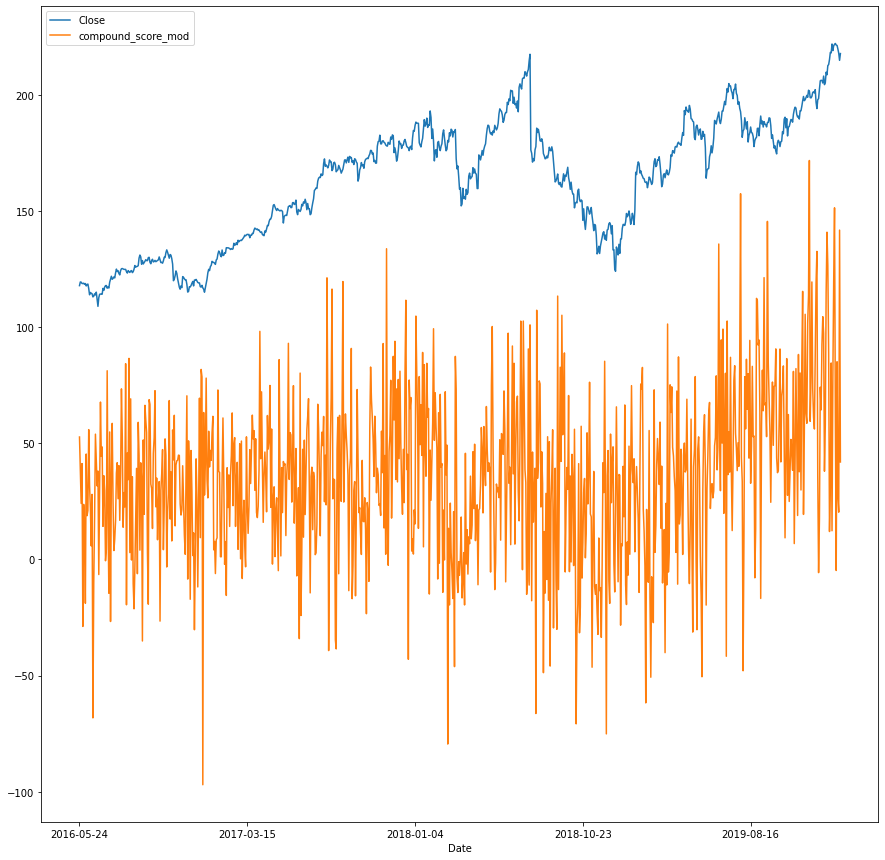

In [16]:
test[['Close', 'compound_score_mod']].plot(figsize = (15,15))

In [17]:
test1 = test.copy()

<AxesSubplot:xlabel='Date'>

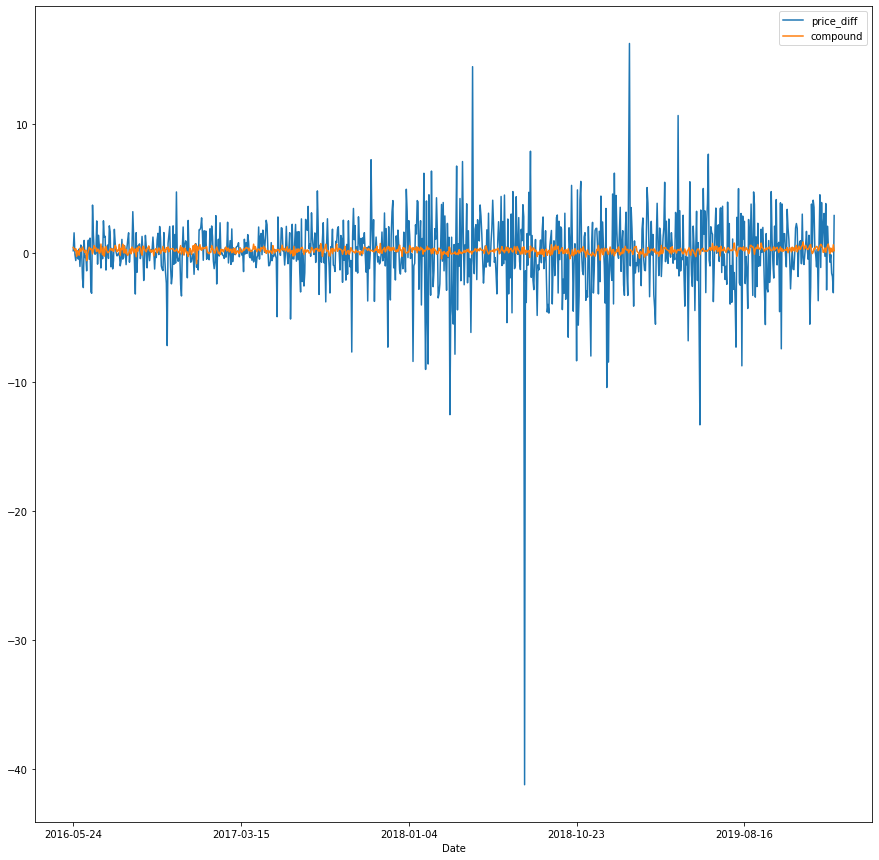

In [18]:
test1[['price_diff', 'compound']].plot(figsize = (15,15))

In [19]:
test1['same_sign'] = test1['price_diff']*test1['compound'] > 0 
print(test1['same_sign'].sum())
print(len(test1))

467
908


### Linear Regression

In [20]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from random import seed

In [21]:
seed(4222)
xvar, yvar = test1[['SMA20', 'SMA50', 'SMA100']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

In [22]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

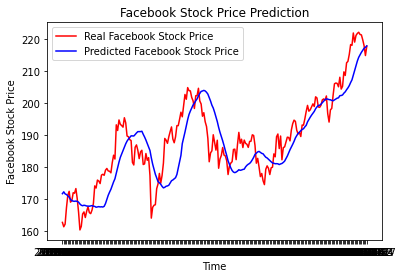

Mean squared error: 54.704
Coefficient of determination: 0.704
Adjusted R Squared: 0.700


In [23]:
pyplot.plot(y_test, color = 'red', label = 'Real Facebook Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Facebook Stock Price')
pyplot.title('Facebook Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Facebook Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

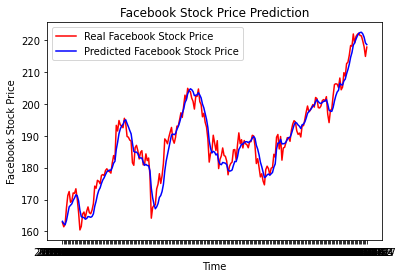

Mean squared error: 7.982
Coefficient of determination: 0.957
Adjusted R Squared: 0.956


In [24]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Facebook Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Facebook Stock Price')
pyplot.title('Facebook Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Facebook Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

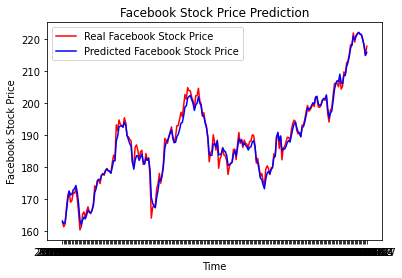

Mean squared error: 2.256
Coefficient of determination: 0.988
Adjusted R Squared: 0.987


In [25]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Facebook Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Facebook Stock Price')
pyplot.title('Facebook Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Facebook Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

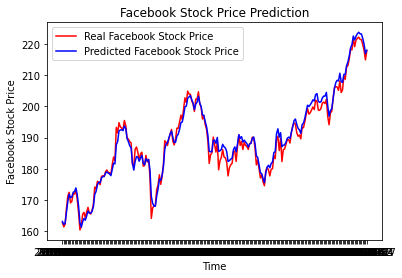

Mean squared error: 3.342
Coefficient of determination: 0.982
Adjusted R Squared: 0.981


In [26]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Facebook Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Facebook Stock Price')
pyplot.title('Facebook Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Facebook Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

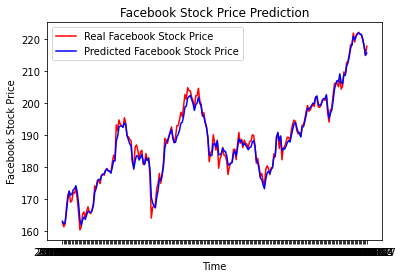

Mean squared error: 2.276
Coefficient of determination: 0.988
Adjusted R Squared: 0.987


In [40]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'neg', 'neu', 'pos', 'compound']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Facebook Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Facebook Stock Price')
pyplot.title('Facebook Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Facebook Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

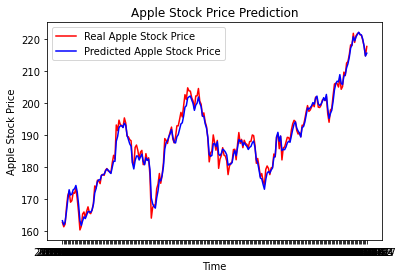

Mean squared error: 2.301
Coefficient of determination: 0.988
Adjusted R Squared: 0.987


In [41]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', '0','1','2','3','4','5','6','7','8','9']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

In [28]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs

In [29]:
test.columns

Index(['neg', 'neu', 'pos', 'compound', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'Sentiment', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Adj Close', 'Movement', 'price_diff', 'TNX', 'SMA20', 'SMA50',
       'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI',
       'compound_score_mod'],
      dtype='object')

In [30]:
test2 = test.drop('Close', inplace=False, axis=1)    # inplace=False means the operation would not work on the original object. axis=1 means we are dropping the column, not the row.
test2.drop('Adj Close', inplace=True, axis=1)
test2.drop('price_diff', inplace=True, axis=1)
test2.drop('Movement', inplace=True, axis=1)
test2.drop('High', inplace=True, axis=1)
test2.drop('Low', inplace=True, axis=1)
test2.columns

Index(['neg', 'neu', 'pos', 'compound', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'Sentiment', 'Open', 'Volume', 'TNX', 'SMA20', 'SMA50',
       'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI',
       'compound_score_mod'],
      dtype='object')

In [31]:
classifier = linear_model.LinearRegression()
xvar, yvar = test2, test1['Close']
x_train, x_test, y_train, y_test = train_test_split(xvar, yvar, test_size=0.25, random_state=0)

# Build step forward feature selection
forward_selection = sfs(classifier, n_features_to_select = 10, direction='forward', scoring='neg_mean_squared_error', cv=3)

# Perform SFFS
forward_selection = forward_selection.fit(x_train, y_train)

test2.columns[forward_selection.support_]

Index(['Open', 'Volume', 'SMA20', 'SMA50', 'EMA10', 'EMA20', 'EMA40', 'MACD',
       'Signal', 'RSI'],
      dtype='object')

In [32]:
classifier = linear_model.LinearRegression()
xvar, yvar = test2, test1['Close']
x_train, x_test, y_train, y_test = train_test_split(xvar, yvar, test_size=0.25, random_state=0)

# Build step forward feature selection
backward_selection = sfs(classifier, n_features_to_select = 10, direction='backward', scoring='neg_mean_squared_error', cv=3)

# Perform SFFS
backward_selection = backward_selection.fit(x_train, y_train)

test2.columns[backward_selection.support_]

Index(['Open', 'Volume', 'SMA20', 'SMA50', 'EMA10', 'EMA20', 'EMA40', 'MACD',
       'Signal', 'RSI'],
      dtype='object')

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

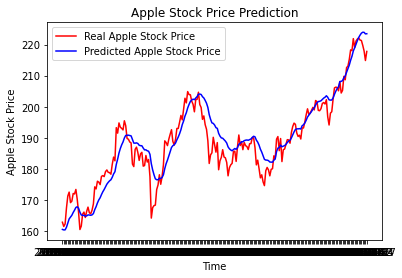

Mean squared error: 22.95
Coefficient of determination: 0.876
Adjusted R Squared: 0.874


In [34]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

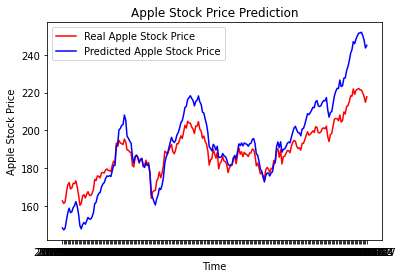

Mean squared error: 125.54
Coefficient of determination: 0.322
Adjusted R Squared: 0.303


In [35]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

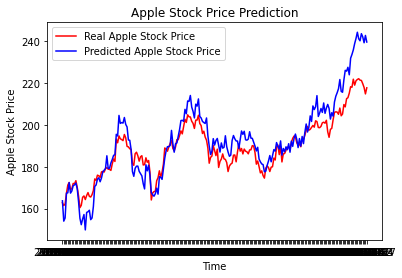

Mean squared error: 59.97
Coefficient of determination: 0.676
Adjusted R Squared: 0.661


In [36]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'neg', 'neu', 'pos', 'compound']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real Apple Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
pyplot.title('Apple Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('Apple Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))